In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Select and compile model


        About: 

        SIR model - expects I,R,D; sums R and D columns 

        fits I and RD
        
S: susceptible
I: infected
RD: recovered_dead


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


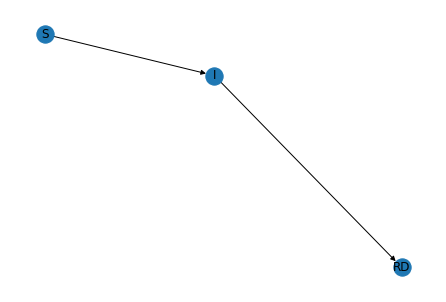

In [3]:
import MBS_epidemic_concentration_models as models
model = models.model1a()
model.plotnetwork()

In [4]:
stanrunmodel = pystan.StanModel(model_code=model.stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3546012605c544f2fa3caecba882fb18 NOW.


In [5]:
#this needs to match the model code used
# stan_data = {
# 'n_theta':5,
# 'n_difeq':5,
# 'n_ostates':3
# }






# Load data from JHU



In [6]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)




## Make JHU ROI DF

### Enter country 

In [7]:
roi = "United Kingdom"

t0 assumed to be: day 57


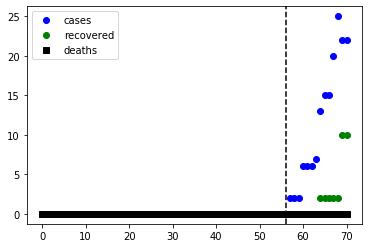

In [9]:
dfc2 = dfc.loc[dfc['Country/Region']==roi]
dfd2 = dfd.loc[dfd['Country/Region']==roi]
dfr2 = dfr.loc[dfr['Country/Region']==roi]


DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])

dates = dfc.columns[4:].values

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})


pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 6440000

t0 = np.where(DF["cases"].values>=1)[0][0]# estimated day of first exposure? Need to make this a parameter
model.stan_data['t0'] = t0-1
print("t0 assumed to be: day "+str(t0))
plt.plot(DF["cases"],'bo', label="cases")
plt.plot(DF["recovered"],'go',label="recovered")
plt.plot(DF["deaths"],'ks',label="deaths")

plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
plt.legend()


## Format JHU ROI data for Stan

In [10]:
#truncate time series from t0 on (initial is t0-1)
model.stan_data['ts'] = np.arange(t0,len(dates))  
model.stan_data['y'] = (DF[['cases','recovered','deaths']].to_numpy()).astype(int)[t0:,:]
model.stan_data['n_obs'] = len(dates) - t0

### Enter population manually

In [11]:
model.stan_data['n_pop'] = 100000#pop[roi] 

### Print data for Stan 

In [12]:
print(model.stan_data)

{'n_theta': 2, 'n_difeq': 3, 'n_ostates': 3, 't0': 56, 'ts': array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]), 'y': array([[ 2,  0,  0],
       [ 2,  0,  0],
       [ 2,  0,  0],
       [ 6,  0,  0],
       [ 6,  0,  0],
       [ 6,  0,  0],
       [ 7,  0,  0],
       [13,  2,  0],
       [15,  2,  0],
       [15,  2,  0],
       [20,  2,  0],
       [25,  2,  0],
       [22, 10,  0],
       [22, 10,  0]]), 'n_obs': 14, 'n_pop': 100000}


# Load England School 1978 Influenza data 

In [ ]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# stan_data['t0'] = 0
##truncate time series from t0 on (initial is t0-1)
# stan_data['n_pop'] = pop 
# stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# stan_data['y'] = Y
# stan_data['n_obs'] = len(cases)



# Run Stan 

## Initialize parameters

In [13]:
# Feed in some feasible initial values to start from

# init_par = [{'theta':[0.25,0.01,0.01,0.05,.02],'S0':0.5}] 

init_par = [{'theta':[2.5,0.3],'S0':0.9}] 


## Fit Stan 

In [ ]:
control = {'adapt_delta':0.9}
fit = stanrunmodel.sampling(data = model.stan_data,chains = 1,iter=2000, warmup=1000, init = init_par,control=control)

In [ ]:
print(fit)

In [ ]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])